In [126]:
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [127]:
#https://www.openml.org/d/31
credit_g = fetch_openml('credit-g', version=1)
credit_data = credit_g['data']
credit_data['target'] = credit_g['target']
print(credit_data.shape)

del credit_g

(1000, 21)


In [128]:
## Create Missing Values
credit_data['duration'].iloc[0:46] = np.nan
credit_data['checking_status'].iloc[25:75] = np.nan
credit_data['credit_amount'].iloc[10:54] = 0

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [129]:
hlp.pandas.numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,954,46,5.0%,0,0.0%,20.9,12.0,0.6,1.1,1.0,4.0,9.0,12.0,18.0,24.0,36.0,72.0
credit_amount,"1,000",0,0.0%,44,4.0%,"3,132.9","2,853.4",0.9,1.9,4.3,0.0,740.0,"1,287.8","2,224.0","3,873.5","7,119.8","18,424.0"
installment_commitment,"1,000",0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,"1,000",0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,"1,000",0,0.0%,0,0.0%,35.5,11.4,0.3,1.0,0.6,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,"1,000",0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,"1,000",0,0.0%,0,0.0%,1.2,0.4,0.3,1.9,1.6,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [130]:
hlp.pandas.non_numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,950,50,5.0%,no checking,4,0.4%
credit_history,"1,000",0,0.0%,existing paid,5,0.5%
purpose,"1,000",0,0.0%,radio/tv,10,1.0%
savings_status,"1,000",0,0.0%,<100,5,0.5%
employment,"1,000",0,0.0%,1<=X<4,5,0.5%
personal_status,"1,000",0,0.0%,male single,4,0.4%
other_parties,"1,000",0,0.0%,none,3,0.3%
property_magnitude,"1,000",0,0.0%,car,4,0.4%
other_payment_plans,"1,000",0,0.0%,none,3,0.3%
housing,"1,000",0,0.0%,own,3,0.3%


# Training and Test Data

In [131]:
y_full = credit_data['target']
X_full = credit_data.drop(columns='target')

del credit_data

In [132]:
hlp.pandas.value_frequency(series=y_full)

,Frequency,Percent
good,700,0.7
bad,300,0.3


In [133]:
y_full[0:10]

0    good
1     bad
2    good
3    good
4     bad
5    good
6    good
7    good
8    good
9     bad
Name: target, dtype: category
Categories (2, object): ['good', 'bad']

In [134]:
from sklearn.preprocessing import label_binarize
y_full = label_binarize(y_full, classes=['bad', 'good']).flatten()

In [135]:
y_full[0:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [137]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(800, 20)
800
(200, 20)
200


In [138]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [139]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

In [140]:
np.unique(y_test, return_counts=True)[1] / np.sum(np.unique(y_test, return_counts=True)[1])

array([0.295, 0.705])

# Transformation Pipeline

In [141]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [142]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [143]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute_chooser', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling_chooser', hlp.sklearn_pipeline.TransformerChooser()),
])

In [144]:
non_numeric_pipeline = Pipeline([
    ('encoder_chooser', hlp.sklearn_pipeline.TransformerChooser()),
])

In [145]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [146]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [147]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [148]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'preparation': ColumnTransformer(transformers=[('numeric_pipeline',
                                  Pipeline(steps=[('impute_chooser',
                                                   TransformerChooser()),
                                                  ('scaling_chooser',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric_pipeline',
                                  Pipeline(steps=[('encoder_chooser',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                           

# Grid Search

In [24]:
param_grad = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn_pipeline.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [25]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [26]:
num_folds = 5
num_repeats = 2

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds,
                                            n_repeats=num_repeats,
                                            random_state=2),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                          )
grid_search.fit(X_train, y_train)

del param_grad

## Results

In [28]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.771524602897316
{'model__max_features': 2, 'model__n_estimators': 500, 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': OneHotEncoder(), 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(), 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}


In [29]:
grid_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=grid_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)

In [30]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
grid_search_df.rename(columns=column_new_names, inplace=True)

In [31]:
grid_search_df.head()

,ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,ROC/AUC Training Mean,F1 Mean,F1 95CI.LO,F1 95CI.HI,F1 Training Mean,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,...,Pos. Pred. Val Training Mean,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,True Pos. Rate Training Mean,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
8,0.772,0.747,0.796,1.0,0.841,0.826,0.857,1.0,0.749,0.722,...,1.0,0.962,0.951,0.973,1.0,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
9,0.771,0.746,0.796,1.0,0.842,0.826,0.857,1.0,0.749,0.722,...,1.0,0.964,0.953,0.974,1.0,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
10,0.770,0.745,0.796,1.0,0.836,0.824,0.849,1.0,0.757,0.732,...,1.0,0.936,0.916,0.957,1.0,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
11,0.770,0.744,0.795,1.0,0.837,0.824,0.849,1.0,0.758,0.734,...,1.0,0.935,0.915,0.956,1.0,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
32,0.769,0.743,0.794,1.0,0.836,0.824,0.848,1.0,0.770,0.746,...,1.0,0.918,0.890,0.946,1.0,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [32]:
hlp.sklearn_eval.cv_results_to_dataframe(searcher=grid_search,
                                         num_folds=num_folds,
                                         num_repeats=num_repeats,
                                         return_style=True)

ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,ROC/AUC Training Mean,F1 Mean,F1 95CI.LO,F1 95CI.HI,F1 Training Mean,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,Pos. Pred. Val Training Mean,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,True Pos. Rate Training Mean,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.772,0.747,0.796,1.000,0.841,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.962,0.951,0.973,1.000,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.771,0.746,0.796,1.000,0.842,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.964,0.953,0.974,1.000,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.770,0.745,0.796,1.000,0.836,0.824,0.849,1.000,0.757,0.732,0.782,1.000,0.936,0.916,0.957,1.000,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.770,0.744,0.795,1.000,0.837,0.824,0.849,1.000,0.758,0.734,0.782,1.000,0.935,0.915,0.956,1.000,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.769,0.743,0.794,1.000,0.836,0.824,0.848,1.000,0.770,0.746,0.794,1.000,0.918,0.890,0.946,1.000,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.768,0.742,0.794,1.000,0.835,0.822,0.847,1.000,0.769,0.744,0.794,1.000,0.915,0.887,0.944,1.000,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.767,0.736,0.798,1.000,0.838,0.822,0.853,1.000,0.775,0.748,0.801,1.000,0.914,0.891,0.937,1.000,10,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.767,0.737,0.797,1.000,0.837,0.821,0.852,1.000,0.775,0.747,0.802,1.000,0.912,0.892,0.932,1.000,10,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.767,0.748,0.785,1.000,0.834,0.821,0.847,1.000,0.759,0.733,0.785,1.000,0.928,0.911,0.945,1.000,2,100,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.766,0.747,0.784,1.000,0.830,0.817,0.843,1.000,0.757,0.731,0.782,1.000,0.921,0.904,0.938,1.000,2,100,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [33]:
grid_search_df.fillna(0).groupby('transformer | encoder').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | encoder,
OneHotEncoder(),0.762722
CustomOrdinalEncoder(),0.754611


In [34]:
grid_search_df.fillna(0).groupby('transformer | scaler').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | scaler,
MinMaxScaler(),0.758778
StandardScaler(),0.758556


In [35]:
grid_search_df.fillna(0).groupby('model | n_estimators').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | n_estimators,
500,0.765167
100,0.758500
50,0.752333


In [36]:
grid_search_df.fillna(0).groupby('model | max_features').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | max_features,
2,0.761833
auto,0.758500
10,0.755667


In [37]:
del grid_search_df

# Random Search

In [38]:
from scipy.stats import randint, uniform  # , expon

0.20365929817363626
0.9897769618960433


(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <BarContainer object of 10 artists>)

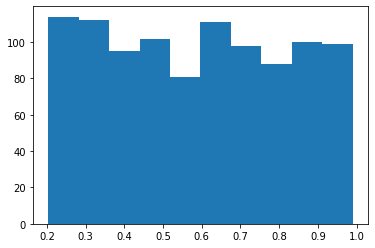

In [39]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

2
99


(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

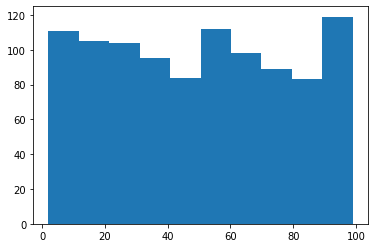

In [40]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

In [41]:
del s

In [42]:
model_param_dict = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [
            OneHotEncoder(),
            hlp.sklearn_pipeline.CustomOrdinalEncoder()
        ],
        'model__n_estimators': randint(50, 5000),
        # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
        'model__max_features':  uniform(.01, .99),
    },
]

In [43]:
num_folds = 5
num_repeats = 2

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=model_param_dict,
    n_iter=30,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    #return_train_score=True,
    n_jobs=-1,
    #verbose=2,
    random_state=42,
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preparation',
                                              ColumnTransformer(transformers=[('numeric_pipeline',
                                                                               Pipeline(steps=[('impute_chooser',
                                                                                                TransformerChooser()),
                                                                                               ('scaling_chooser',
                                                                                                TransformerChooser())]),
                                                                               ['duration',
                                                                                'credit_amount',
                                                                                'installment_commitme

## Results

In [45]:
print(random_search.best_score_)
print(random_search.best_params_)

0.761786753072665
{'model__max_features': 0.02548004267378199, 'model__n_estimators': 2618, 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': CustomOrdinalEncoder(), 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(), 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}


In [46]:
random_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=random_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)

In [47]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
random_search_df.rename(columns=column_new_names, inplace=True)

In [48]:
random_search_df.head()

,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
26,0.762,0.739,0.784,0.025480,2618,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
6,0.761,0.739,0.783,0.191570,4605,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
19,0.761,0.739,0.783,0.193006,4848,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
15,0.759,0.736,0.782,0.248615,1528,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
4,0.759,0.735,0.783,0.030379,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [49]:
hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=random_search,num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=True
)

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.762,0.739,0.784,0.025,"2,618",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.761,0.739,0.783,0.192,"4,605",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.761,0.739,0.783,0.193,"4,848",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.759,0.736,0.782,0.249,"1,528",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.759,0.735,0.783,0.030,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.756,0.735,0.776,0.266,"3,993",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.755,0.734,0.776,0.164,"4,476",OneHotEncoder(),SimpleImputer(),StandardScaler()
0.755,0.733,0.777,0.340,"2,969",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.754,0.732,0.776,0.017,"2,954",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.752,0.730,0.775,0.207,"1,545",OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [50]:
random_search_df.fillna(0).groupby('transformer | encoder').agg({'roc_auc Mean': np.mean}).sort_values(by='roc_auc Mean', ascending=False)

,roc_auc Mean
transformer | encoder,
CustomOrdinalEncoder(),0.750437
OneHotEncoder(),0.744214


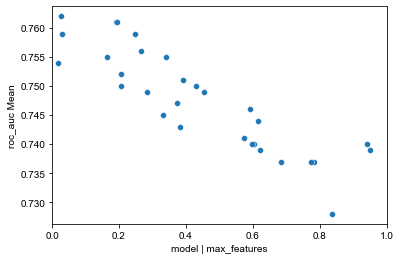

In [51]:
import matplotlib.pyplot as plt
plt.xlim(0, 1)
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df, x="model | max_features", y="roc_auc Mean")
plt.show()

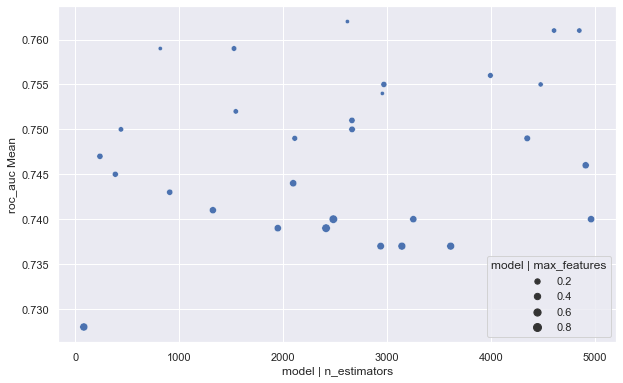

In [52]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                size='model | max_features')
plt.show()

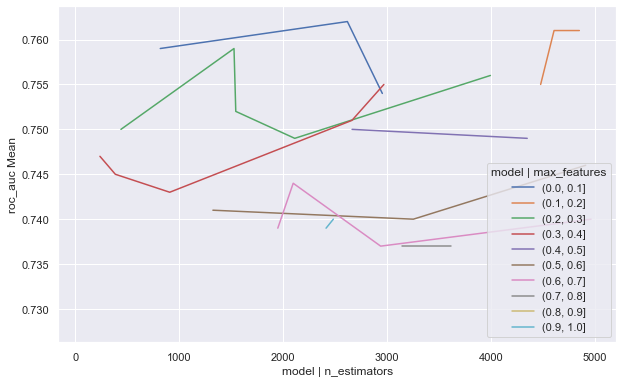

In [53]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)))
plt.show()

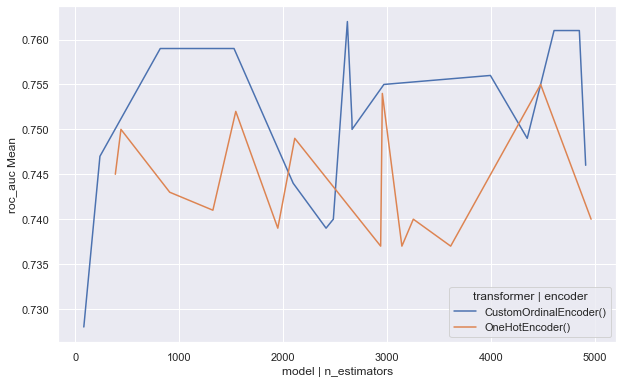

In [54]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
             hue='transformer | encoder')
plt.show()

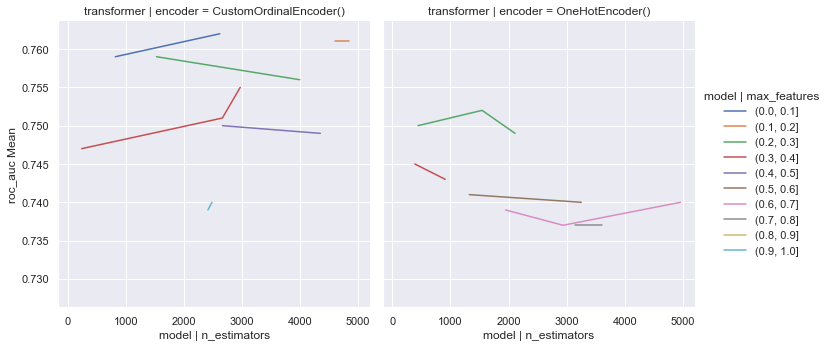

In [55]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.relplot(data=random_search_df,
            kind='line',
            x="model | n_estimators",
            y="roc_auc Mean",
            hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)),
            col='transformer | encoder')
plt.show()

In [56]:
del random_search_df

# skopt.BayesSearchCV

[https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [149]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [153]:
search_space = {
    'preparation__numeric_pipeline__impute_chooser__base_transformer': Categorical([SimpleImputer(strategy='mean')]),
    'preparation__numeric_pipeline__scaling_chooser__base_transformer': Categorical([MinMaxScaler(), StandardScaler()]),
    'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': Categorical([
        OneHotEncoder(),
        hlp.sklearn_pipeline.CustomOrdinalEncoder()
    ]),
    'model__n_estimators': Integer(50, 5000),
    # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
    'model__max_features':  Real(.01, .99),
}

bayes_search = BayesSearchCV(
    estimator=full_pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    #return_train_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)
bayes_search.fit(X_train, y_train)

del search_space

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


## Results

In [154]:
print(bayes_search.best_score_)
print(bayes_search.best_params_)

0.7790040346088256
OrderedDict([('model__max_features', 0.010038932060293042), ('model__n_estimators', 902), ('preparation__non_numeric_pipeline__encoder_chooser__base_transformer', CustomOrdinalEncoder()), ('preparation__numeric_pipeline__impute_chooser__base_transformer', SimpleImputer()), ('preparation__numeric_pipeline__scaling_chooser__base_transformer', StandardScaler())])


In [155]:
bayes_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=bayes_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)

In [156]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
bayes_search_df.rename(columns=column_new_names, inplace=True)

In [157]:
bayes_search_df.head()

,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
10,0.779,0.763,0.795,0.010039,902,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
11,0.772,0.754,0.790,0.010011,3025,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
28,0.770,0.755,0.785,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
22,0.770,0.746,0.795,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
9,0.770,0.751,0.789,0.013558,4098,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


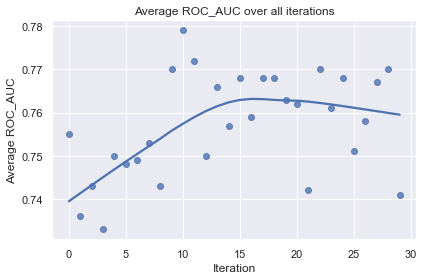

In [158]:
sns.regplot(x=np.arange(0, len(bayes_search_df)), y=bayes_search_df.sort_index()['roc_auc Mean'], lowess=True)
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()

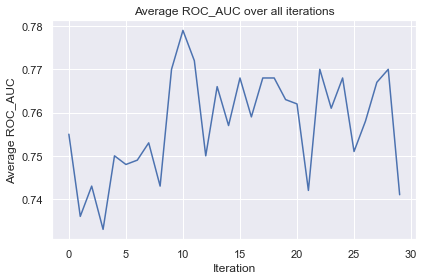

In [159]:
bayes_search_df.sort_index()['roc_auc Mean'].plot()
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()

In [160]:
del bayes_search_df

In [161]:
hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=bayes_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=True
)

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.779,0.763,0.795,0.010,902,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.772,0.754,0.790,0.010,"3,025",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.770,0.755,0.785,0.010,"5,000",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.770,0.746,0.795,0.010,"5,000",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.770,0.751,0.789,0.014,"4,098",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.768,0.746,0.791,0.010,"1,905",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.768,0.746,0.789,0.010,"5,000",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.768,0.739,0.796,0.010,"3,319",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.768,0.748,0.789,0.010,"4,278",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.767,0.742,0.793,0.010,"5,000",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


# Final Model

In [162]:
best_model = bayes_search.best_estimator_

In [163]:
best_model.classes_

array([0, 1])

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [67]:
predicted_scores = best_model.predict_proba(X_train)[:, 1]

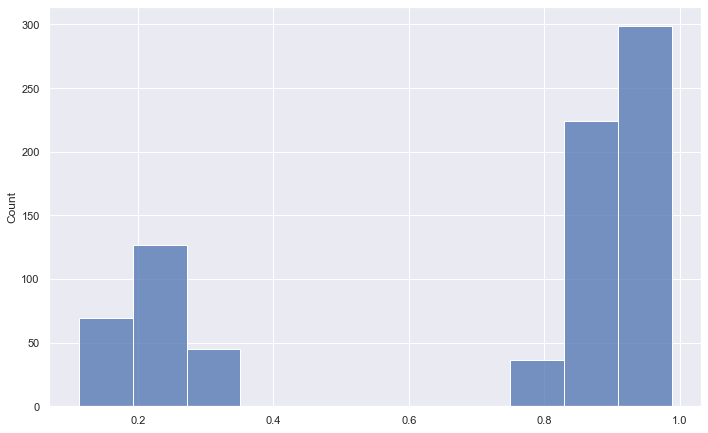

In [68]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [69]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [70]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,1.000,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 559 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,1.000,"100.0% of negative instances were correctly identified.; i.e. 241 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.000,"0.0% of negative instances were incorrectly identified as positive; i.e. 0 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,1.000,"When the model claims an instance is positive, it is correct 100.0% of the time; i.e. out of the 559 times the model predicted ""Good"", it was correct 559 times; a.k.a precision"
Negative Predictive Value,1.000,"When the model claims an instance is negative, it is correct 100.0% of the time; i.e. out of the 241 times the model predicted ""Bad"", it was correct 241 times"
F1 Score,1.000,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,1.000,100.0% of instances were correctly identified
Error Rate,0.000,0.0% of instances were incorrectly identified


In [71]:
del predicted_scores

## Test Set Evaluation

In [72]:
predicted_scores = best_model.predict_proba(X_test)[:, 1]

In [73]:
predicted_scores

array([0.56798246, 0.64309211, 0.37171053, 0.66666667, 0.85800439,
       0.66557018, 0.90405702, 0.58333333, 0.87445175, 0.8004386 ,
       0.80811404, 0.57510965, 0.7872807 , 0.42598684, 0.28563596,
       0.66337719, 0.80372807, 0.83662281, 0.49177632, 0.70230263,
       0.72039474, 0.73903509, 0.87445175, 0.97313596, 0.94078947,
       0.59210526, 0.4627193 , 0.58881579, 0.71326754, 0.80208333,
       0.67653509, 0.78618421, 0.63212719, 0.73464912, 0.77083333,
       0.72258772, 0.5       , 0.77083333, 0.89199561, 0.51315789,
       0.70942982, 0.79166667, 0.66611842, 0.80098684, 0.8497807 ,
       0.72861842, 0.56578947, 0.63322368, 0.70230263, 0.75712719,
       0.44133772, 0.86567982, 0.70010965, 0.50274123, 0.75      ,
       0.74506579, 0.9002193 , 0.47258772, 0.47697368, 0.81304825,
       0.76973684, 0.59758772, 0.62774123, 0.91666667, 0.6129386 ,
       0.69078947, 0.86019737, 0.60964912, 0.60197368, 0.78782895,
       0.57072368, 0.85416667, 0.78015351, 0.66995614, 0.61074

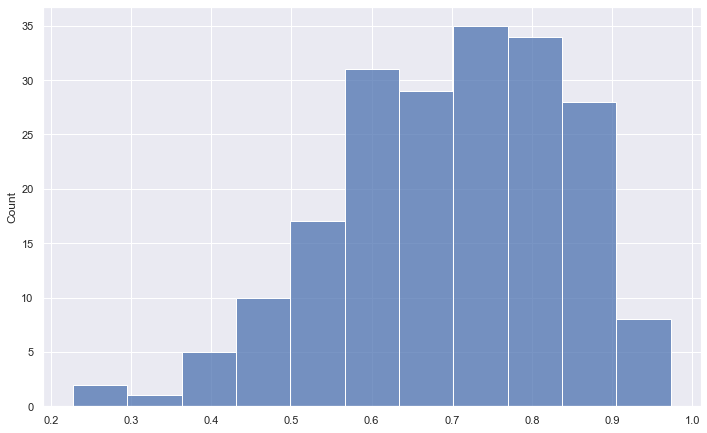

In [74]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [75]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0    Not Defaulted
1        Defaulted
2        Defaulted
3        Defaulted
4        Defaulted
dtype: object

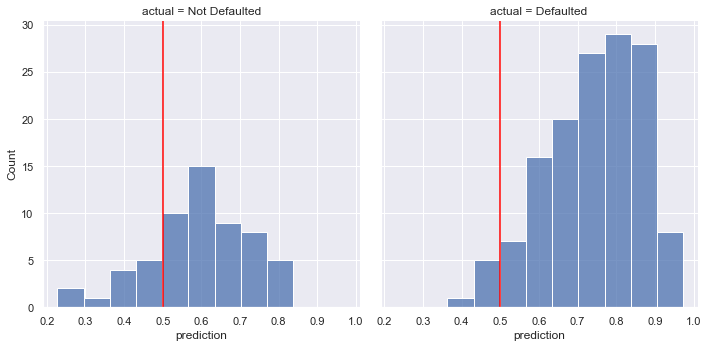

In [76]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [77]:
del y_test_cat
del axes

In [78]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

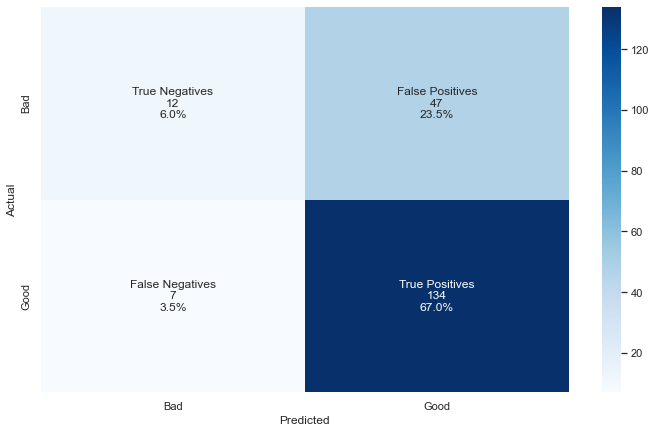

In [79]:
evaluator.plot_confusion_matrix()

In [80]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.796,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.950,"95.0% of positive instances were correctly identified.; i.e. 134 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.203,"20.3% of negative instances were correctly identified.; i.e. 12 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.797,"79.7% of negative instances were incorrectly identified as positive; i.e. 47 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.050,"5.0% of positive instances were incorrectly identified as negative; i.e. 7 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.740,"When the model claims an instance is positive, it is correct 74.0% of the time; i.e. out of the 181 times the model predicted ""Good"", it was correct 134 times; a.k.a precision"
Negative Predictive Value,0.632,"When the model claims an instance is negative, it is correct 63.2% of the time; i.e. out of the 19 times the model predicted ""Bad"", it was correct 12 times"
F1 Score,0.832,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.730,73.0% of instances were correctly identified
Error Rate,0.270,27.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [81]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [82]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


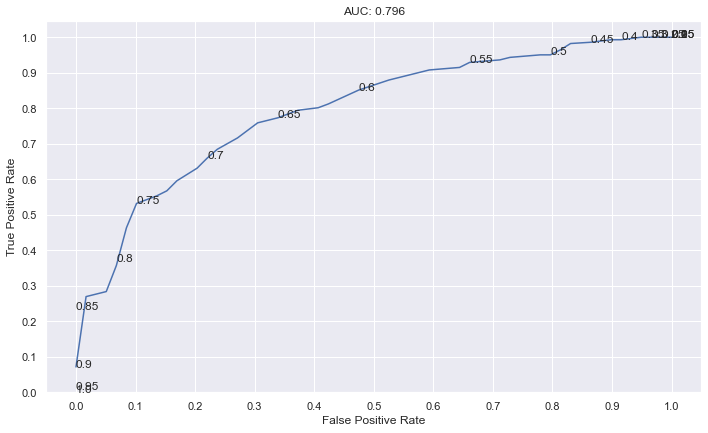

In [83]:
evaluator.plot_auc_curve()
plt.grid()

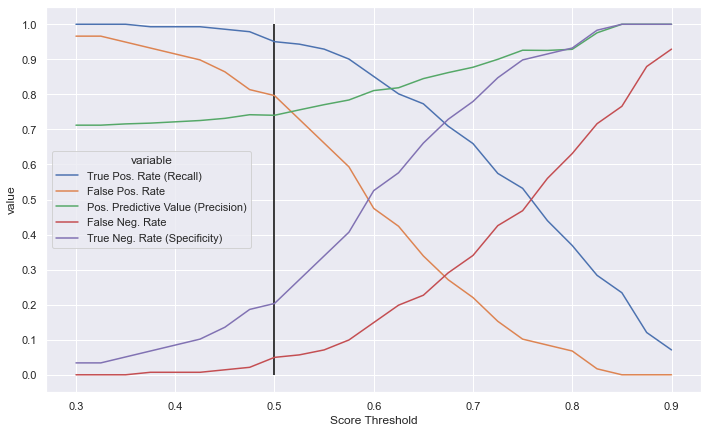

In [84]:
evaluator.plot_threshold_curves()
plt.grid()

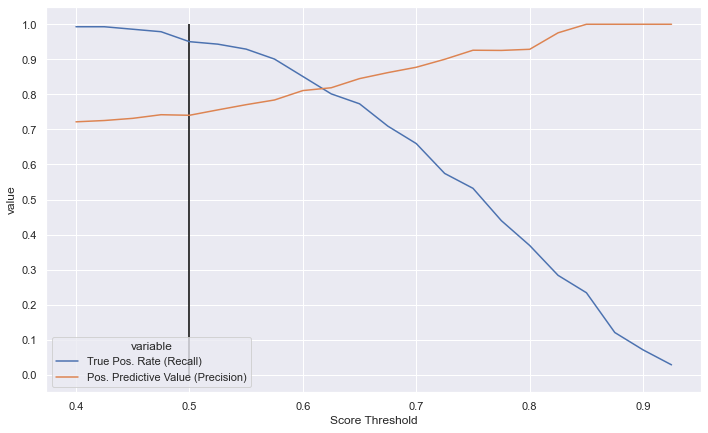

In [85]:
evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95))
plt.grid()

In [86]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,10,10,0.07,1.42
10,10,10,20,0.14,1.42
15,10,10,30,0.21,1.42
20,10,9,39,0.28,1.38
25,10,7,46,0.33,1.30
30,10,10,56,0.40,1.32
35,10,9,65,0.46,1.32
40,10,9,74,0.52,1.31
45,10,7,81,0.57,1.28


In [87]:
del predicted_scores

## Feature Importance

todo: how to get features names out of final_estimator?

In [88]:
del numeric_pipeline
del non_numeric_pipeline
del transformations_pipeline
del random_forest_model
del full_pipeline

## Build Final Model

In [89]:
grid_search.best_params_

{'model__max_features': 2,
 'model__n_estimators': 500,
 'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': OneHotEncoder(),
 'preparation__numeric_pipeline__impute_chooser__base_transformer': SimpleImputer(),
 'preparation__numeric_pipeline__scaling_chooser__base_transformer': MinMaxScaler()}

In [90]:
bayes_search.best_params_

OrderedDict([('model__max_features', 0.01),
             ('model__n_estimators', 1824),
             ('preparation__non_numeric_pipeline__encoder_chooser__base_transformer',
              CustomOrdinalEncoder()),
             ('preparation__numeric_pipeline__impute_chooser__base_transformer',
              SimpleImputer()),
             ('preparation__numeric_pipeline__scaling_chooser__base_transformer',
              MinMaxScaler())])

In [91]:
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer()),
    ('scale', MinMaxScaler()),
])

In [92]:
non_numeric_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
])

In [93]:
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

In [94]:
random_forest_model = RandomForestClassifier(random_state=42, max_features=10, n_estimators=500)

In [95]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [96]:
full_pipeline.fit(X=X_full, y=y_full)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents']),
                                                 ('non_numeric_pipeline',
                                                  Pipeline(steps=[('encoder',
                                              

In [97]:
final_model = full_pipeline.named_steps['model']
final_model

RandomForestClassifier(max_features=10, n_estimators=500, random_state=42)

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

```
clf.named_steps['preparation'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)
```

In [98]:
new_non_numeric_columns = full_pipeline.named_steps['preparation'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()
new_non_numeric_columns = list(new_non_numeric_columns)

In [99]:
len(new_non_numeric_columns)

55

In [100]:
len(final_model.feature_importances_)

62

In [101]:
final_column_names = numeric_columns + new_non_numeric_columns

In [102]:
pd.DataFrame({
    'importance (final)': final_model.feature_importances_,
    'importance (cross val)': grid_search.best_estimator_._final_estimator.feature_importances_
    
}, index=final_column_names).\
sort_values(by='importance (final)', ascending=False).\
style.bar(color=hlp.color.GRAY, vmin=0)

,importance (final),importance (cross val)
credit_amount,0.104054,0.081767
age,0.084570,0.072054
duration,0.074995,0.063923
checking_status_no checking,0.047417,0.033809
checking_status_<0,0.040988,0.033009
installment_commitment,0.034824,0.038051
residence_since,0.032843,0.037222
credit_history_critical/other existing credit,0.022264,0.020246
savings_status_<100,0.020792,0.020250
purpose_new car,0.018736,0.018526


# TODO

- get feature importance for model that has various transformations (would have to build pipeline manually based on selected transformers since transformers are being tuned via grid-search)
    - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
    - https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
   
```
grid_search.best_estimator_._final_estimator.feature_importances_
grid_search.best_estimator_._final_estimator.feature_importances_.shape
```

right now we can get importances but can't get feature names since it is being

In [103]:
#grid_search.best_estimator_.named_steps['preparation'].transformers[1][1].named_steps['encoder_chooser'].base_transformer.get_feature_names()

In [104]:
grid_search.best_estimator_._final_estimator.feature_importances_

array([0.06392319, 0.08176671, 0.0380507 , 0.03722161, 0.07205391,
       0.02128217, 0.01135315, 0.01975279, 0.03300944, 0.00656691,
       0.03380932, 0.00601217, 0.00968149, 0.02024632, 0.00926076,
       0.01689088, 0.01231891, 0.01122847, 0.0028823 , 0.00874858,
       0.01408273, 0.01852644, 0.00232178, 0.01794846, 0.00393875,
       0.0012857 , 0.0097917 , 0.00945918, 0.00701141, 0.0202496 ,
       0.0060604 , 0.01293276, 0.01671606, 0.01361385, 0.01446542,
       0.01615652, 0.00922622, 0.01661636, 0.00602843, 0.00878087,
       0.01772468, 0.00559852, 0.00596786, 0.00940453, 0.01641875,
       0.01420544, 0.01289265, 0.01627603, 0.01343604, 0.01682256,
       0.00647033, 0.00979669, 0.01880648, 0.01291542, 0.01210869,
       0.01706706, 0.00274172, 0.0117306 , 0.01620724, 0.0158297 ,
       0.00347457, 0.00283206])

- future importance
    - https://www.kaggle.com/general/175075
        - LOFO (Leave one feature out) for feature importance.
    - https://explained.ai/rf-importance/

# Sandbox

## Fit Regression on Cross Validation

In [215]:
bayes_search_df = hlp.sklearn_eval.cv_results_to_dataframe(
    searcher=bayes_search,
    num_folds=num_folds,
    num_repeats=num_repeats,
    return_style=False
)
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
bayes_search_df.rename(columns=column_new_names, inplace=True)
bayes_search_df = bayes_search_df.drop(columns=['roc_auc 95CI.LO', 'roc_auc 95CI.HI'])
bayes_search_df.head()

,roc_auc Mean,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
10,0.779,0.010039,902,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
11,0.772,0.010011,3025,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
28,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
22,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
9,0.770,0.013558,4098,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [216]:
cleaned_column_names = [''.join(e for e in x.replace(' ', '_') if e == '_' or e.isalnum()) for x in bayes_search_df.columns.tolist()]
cleaned_column_names = dict(zip(bayes_search_df.columns.tolist(), cleaned_column_names))
bayes_search_df.rename(columns=cleaned_column_names, inplace=True)

del cleaned_column_names

bayes_search_df.head()

,roc_auc_Mean,model__max_features,model__n_estimators,transformer__encoder,transformer__imputer,transformer__scaler
10,0.779,0.010039,902,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
11,0.772,0.010011,3025,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
28,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
22,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
9,0.770,0.013558,4098,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [219]:
#bayes_search_df = bayes_search_df[['roc_auc_Mean', 'model__max_features', 'model__n_estimators']]
bayes_search_df

,roc_auc_Mean,model__max_features,model__n_estimators,transformer__encoder,transformer__imputer,transformer__scaler
10,0.779,0.010039,902,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
11,0.772,0.010011,3025,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
28,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
22,0.770,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
9,0.770,0.013558,4098,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
15,0.768,0.010155,1905,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
18,0.768,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
24,0.768,0.010000,3319,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
17,0.768,0.010103,4278,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
27,0.767,0.010000,5000,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [259]:
bayes_search_df['transformer__scaler']

10    StandardScaler()
11      MinMaxScaler()
28    StandardScaler()
22    StandardScaler()
9     StandardScaler()
15    StandardScaler()
18      MinMaxScaler()
24      MinMaxScaler()
17    StandardScaler()
27    StandardScaler()
13      MinMaxScaler()
19      MinMaxScaler()
20    StandardScaler()
23    StandardScaler()
16    StandardScaler()
26      MinMaxScaler()
14      MinMaxScaler()
0     StandardScaler()
7       MinMaxScaler()
25      MinMaxScaler()
12    StandardScaler()
4     StandardScaler()
6     StandardScaler()
5     StandardScaler()
8       MinMaxScaler()
2       MinMaxScaler()
21      MinMaxScaler()
29    StandardScaler()
1     StandardScaler()
3     StandardScaler()
Name: transformer__scaler, dtype: object

In [218]:
import statsmodels.formula.api as smf

y_column = 'roc_auc_Mean'
X_columns = bayes_search_df.columns.tolist()
X_columns.remove(y_column)
X_columns = hlp.string.collapse(X_columns, separate=" + ", surround="")

formula = f"{y_column} ~ {X_columns}"
print(formula)
model = smf.ols(formula=formula, data = bayes_search_df)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ model__max_features + model__n_estimators + transformer__encoder + transformer__imputer + transformer__scaler
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     19.95
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.74e-07
Time:                        13:21:24   Log-Likelihood:                 112.22
No. Observations:                  30   AIC:                            -214.4
Df Residuals:                      25   BIC:                            -207.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|  

In [257]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit_transform(bayes_search_df)

numeric_columns = hlp.pandas.get_numeric_columns(bayes_search_df)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(bayes_search_df)

print(numeric_columns)
print(non_numeric_columns)

numeric_pipeline = Pipeline([
    ('scaling_chooser', StandardScaler()),
])

transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', 'passthrough', non_numeric_columns)
])

bayes_search_transformed = transformations_pipeline.fit_transform(bayes_search_df)
bayes_search_transformed = pd.DataFrame(bayes_search_transformed,
                                        columns= numeric_columns + non_numeric_columns)
bayes_search_transformed

['roc_auc_Mean', 'model__max_features', 'model__n_estimators']
['transformer__encoder', 'transformer__imputer', 'transformer__scaler']


,roc_auc_Mean,model__max_features,model__n_estimators,transformer__encoder,transformer__imputer,transformer__scaler
0,1.842462,-0.802639,-1.228072,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
1,1.247205,-0.802715,-0.065131,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
2,1.077131,-0.802747,1.016737,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
3,1.077131,-0.802747,1.016737,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
4,1.077131,-0.792863,0.522638,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
5,0.907058,-0.802316,-0.678647,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
6,0.907058,-0.802747,1.016737,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
7,0.907058,-0.802747,0.095917,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
8,0.907058,-0.802462,0.621239,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
9,0.822021,-0.802747,1.016737,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


<AxesSubplot:>

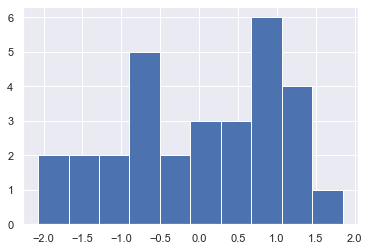

In [278]:
bayes_search_transformed['roc_auc_Mean'].hist()

In [272]:
bayes_search_transformed['roc_auc_Mean'] = bayes_search_transformed['roc_auc_Mean'].astype('float')
bayes_search_transformed['model__max_features'] = bayes_search_transformed['model__max_features'].astype('float')
bayes_search_transformed['model__n_estimators'] = bayes_search_transformed['model__n_estimators'].astype('float')


In [273]:
print(formula)
model = smf.ols(formula=formula,
                data = bayes_search_transformed)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ model__max_features + model__n_estimators + transformer__encoder + transformer__imputer + transformer__scaler
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     19.95
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.74e-07
Time:                        14:15:30   Log-Likelihood:                -21.068
No. Observations:                  30   AIC:                             52.14
Df Residuals:                      25   BIC:                             59.14
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|  

<AxesSubplot:>

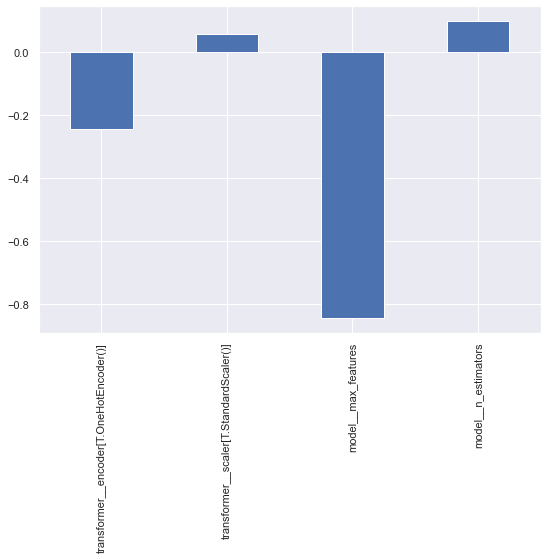

In [274]:
coefficients = results.params[results.params.index != 'Intercept']
#coefficients.reindex(coefficients.abs().sort_values(ascending=False).index).plot(kind='bar', figsize=(9, 6))
coefficients.plot(kind='bar', figsize=(9, 6))

<AxesSubplot:>

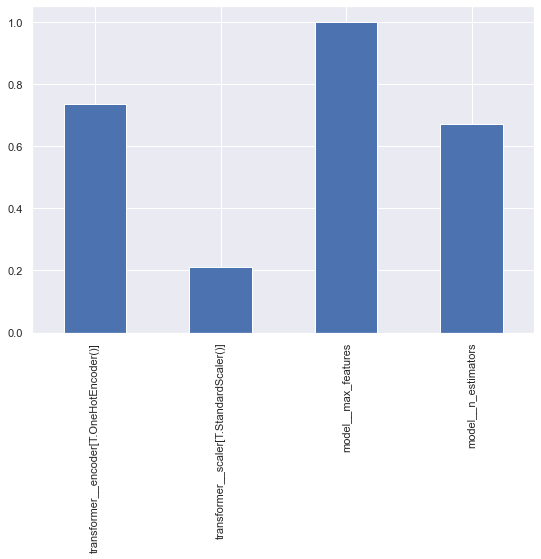

In [275]:
(1 - results.pvalues[results.pvalues.index != 'Intercept']).plot(kind='bar', figsize=(9, 6))

In [ ]:
coefficients = results.params[results.params.index != 'Intercept']
coefficients.reindex(coefficients.abs().sort_values(ascending=False).index).plot(kind='bar', figsize=(9, 6))